###  Импорт необходимых библиотек 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor
import scipy.stats as stats
import xgboost as xgb

### Загрузка данных

In [52]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Просмотр данных

In [53]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Визуализация данных

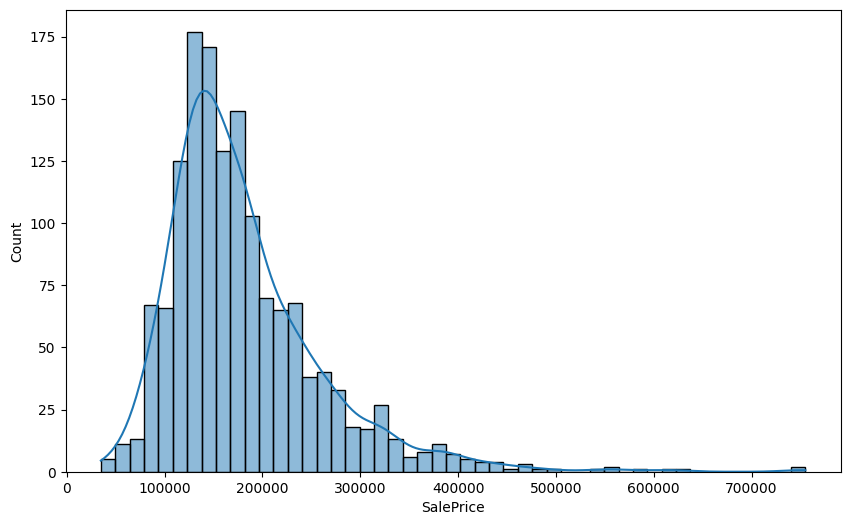

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

In [56]:
train_df_copy = train_df.drop('Id', axis=1)

In [57]:
hist_df = train_df_copy.select_dtypes(include = ['float64', 'int64'])

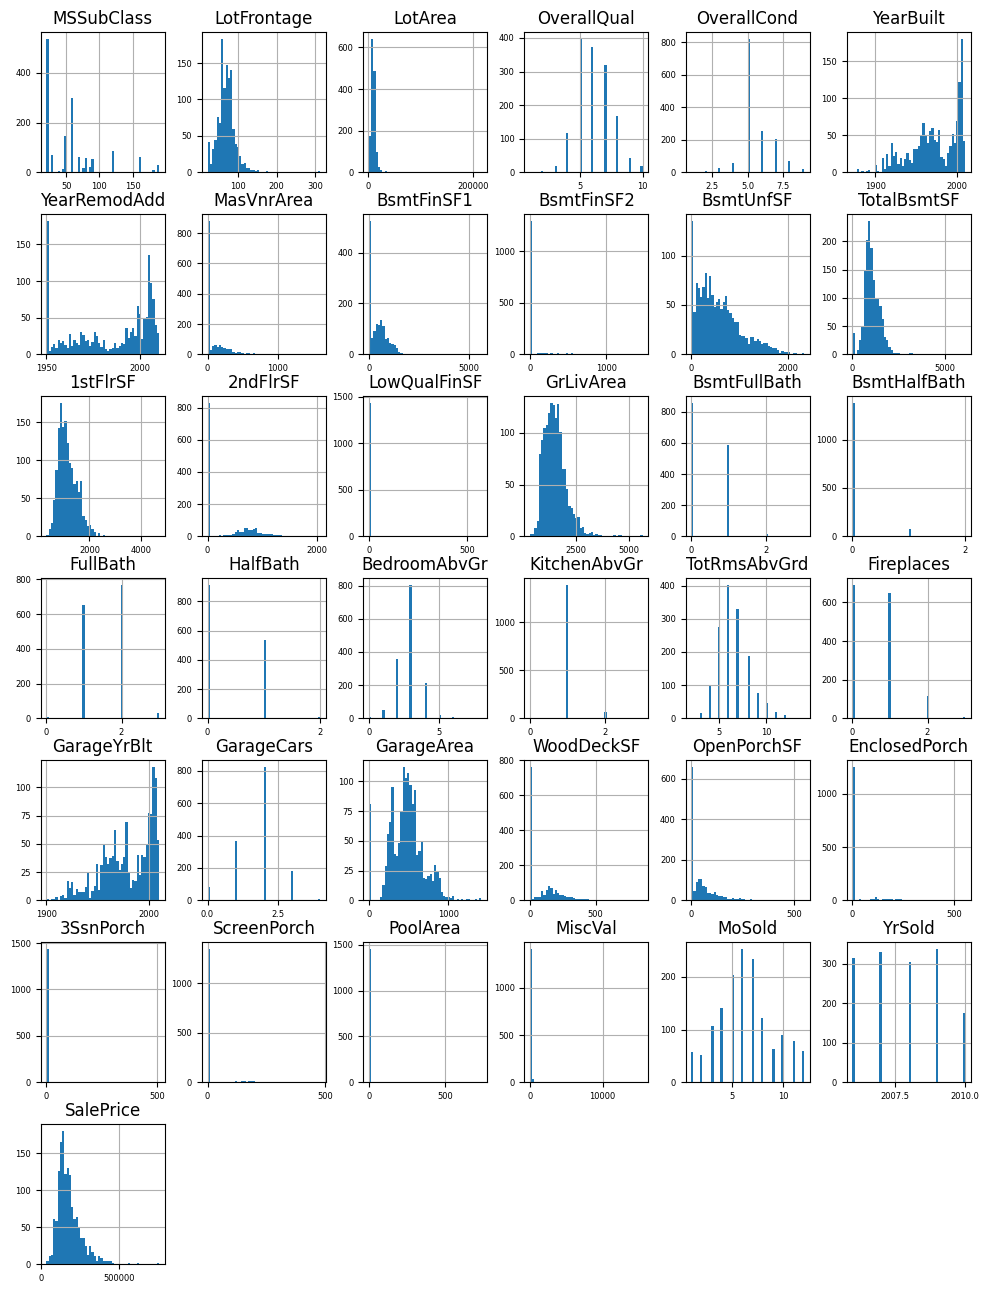

In [58]:
hist_df.hist(figsize=(12, 16), xlabelsize=6, ylabelsize=6,bins=50);

### Изучение данных

In [59]:
file_path = 'data_description.txt'

In [60]:
with open(file_path, 'r') as f:
    text = f.read()
print(text)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Соедининение датафреймов в один

In [61]:
full_df = pd.concat([train_df, test_df])

### Создание новых признаков

In [62]:
def custom_features(df):
    df['LivingSpace'] = df[['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
    df['PoolAvailable'] = (df['PoolArea'] > 0).astype(int)
    df['PorchAreaTotal'] = df[['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch']].sum(axis=1)
    df['BuildingArea'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
    df['GarageAvailable'] = (df['GarageArea'] > 0).astype(int) 
    df['BasementAvailable'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['BuildRemodYear'] = df['YearBuilt'] + df['YearRemodAdd']   
    df['FireplaceAvailable'] = (df['Fireplaces'] > 0).astype(int)
    df['SecondFloorAvailable'] = (df['2ndFlrSF'] > 0).astype(int)
    df['TotalBaths'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    return df

In [63]:
full_df = custom_features(full_df)

### Поиск корреляции

In [64]:
corr_df = full_df.select_dtypes(include=[float, int])
corr_df.corr()['SalePrice'].sort_values()

KitchenAbvGr           -0.135907
EnclosedPorch          -0.128578
MSSubClass             -0.084284
OverallCond            -0.077856
YrSold                 -0.028923
LowQualFinSF           -0.025606
Id                     -0.021917
MiscVal                -0.021190
BsmtHalfBath           -0.016844
BsmtFinSF2             -0.011378
3SsnPorch               0.044584
MoSold                  0.046432
PoolArea                0.092404
PoolAvailable           0.093708
ScreenPorch             0.111447
SecondFloorAvailable    0.137656
BasementAvailable       0.152829
BedroomAbvGr            0.168213
PorchAreaTotal          0.195739
BsmtUnfSF               0.214479
BsmtFullBath            0.227122
GarageAvailable         0.236832
LotArea                 0.263843
HalfBath                0.284108
OpenPorchSF             0.315856
2ndFlrSF                0.319334
WoodDeckSF              0.324413
LotFrontage             0.351799
BsmtFinSF1              0.386420
Fireplaces              0.466929
FireplaceA

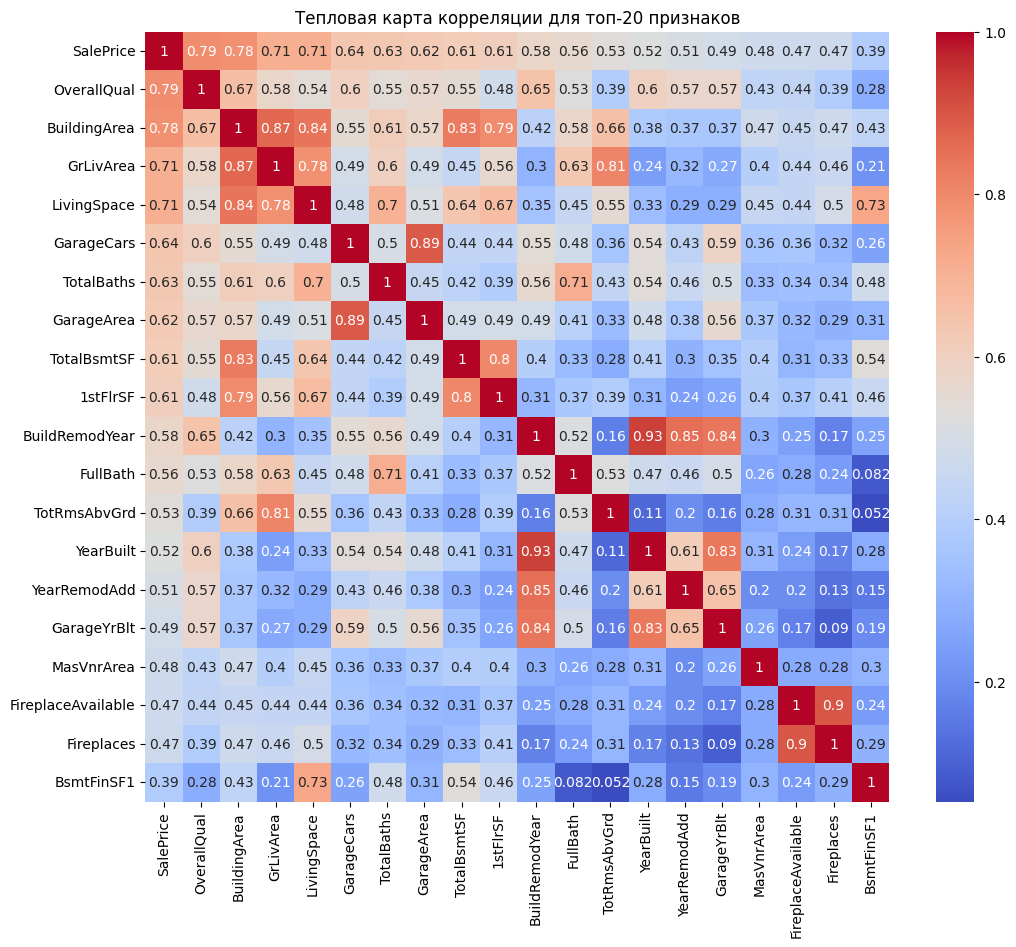

In [65]:
plt.figure(figsize=(12, 10))
corr_matrix = full_df.select_dtypes(include=[float, int]).corr()
top_20_corr = corr_matrix['SalePrice'].sort_values(ascending=False)[:20]
sns.heatmap(full_df[top_20_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции для топ-20 признаков')
plt.show()

### Графики распределения для ключевых признаков

In [66]:
full_df_copy = full_df.reset_index(drop=True)

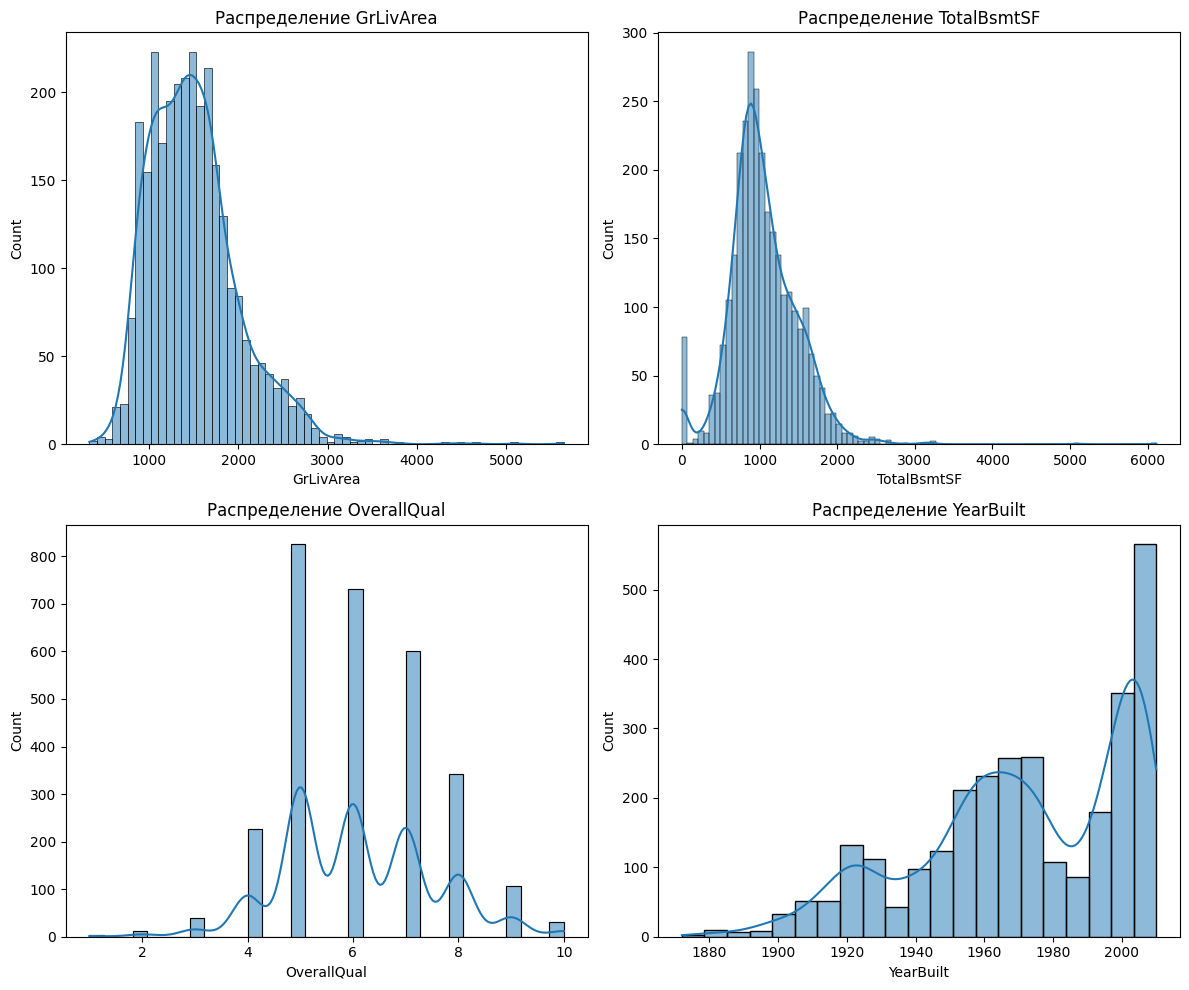

In [67]:
key_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, feature in enumerate(key_features):
    sns.histplot(data=full_df_copy, x=feature, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

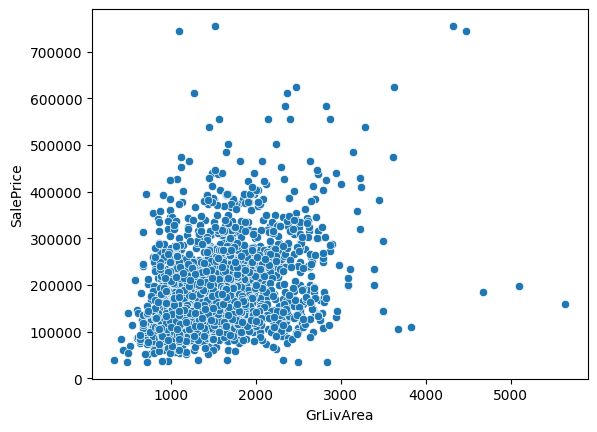

In [68]:
sns.scatterplot(data=full_df, x='GrLivArea', y='SalePrice')
plt.show()

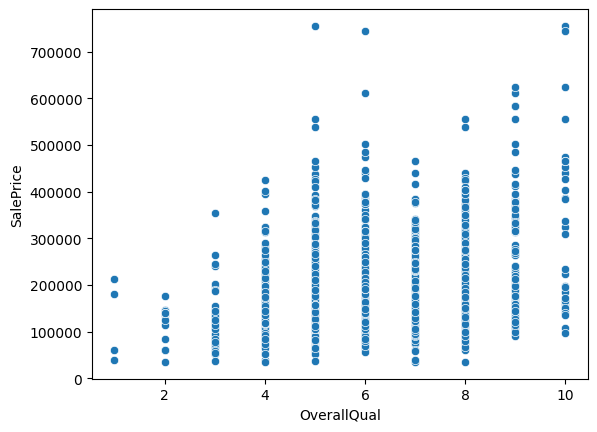

In [69]:
sns.scatterplot(data=full_df, x='OverallQual', y='SalePrice')
plt.show()

### Функции для пропущенных значений

In [70]:
def percent_missing(df):
    total = 100 *df.isnull().sum() / len(df)
    total = total[total > 0].sort_values(ascending=False)
    return total

In [71]:
def preprocess(df):
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.mean()) 
    
    for column in df.select_dtypes(exclude='number').columns:
        df[column] = df[column].fillna('None')
    
    for column in df.select_dtypes(include='number').columns:
        df[column] = df[column].fillna(0)
    
    return df

#### Высчет процента отсутствия данных 

In [72]:
percent_nan = percent_missing(full_df)
percent_nan

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
SalePrice       49.982871
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrArea       0.787941
MSZoning         0.137033
Functional       0.068517
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Utilities        0.068517
TotalBaths       0.068517
KitchenQual      0.034258
Electrical       0.034258
TotalBsmtSF      0.034258
GarageCars       0.034258
GarageArea       0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64

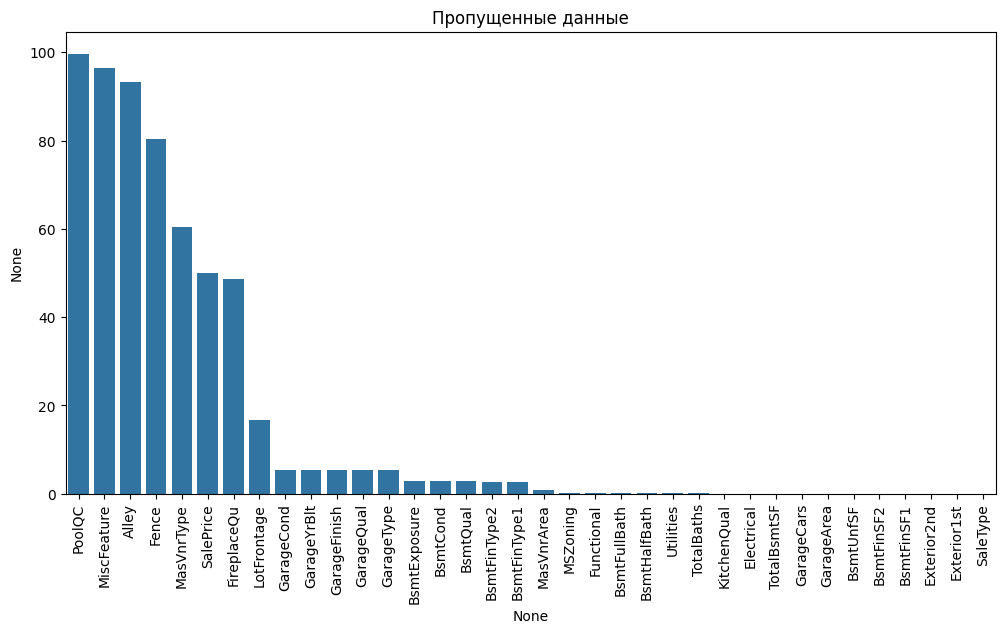

In [73]:
missing_data = percent_missing(full_df)
plt.figure(figsize=(12,6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.xticks(rotation=90)
plt.title('Пропущенные данные')
plt.savefig('missingdata.png', dpi=300, bbox_inches='tight')
plt.show()

### Обработка пропущенных значений

In [74]:
full_df = preprocess(full_df)

In [75]:
percent_nan = percent_missing(full_df)
percent_nan

Series([], dtype: float64)

### Применение OneHotEnconding

In [76]:
def encode(df):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    categorical_columns = list(df.select_dtypes(exclude='number').columns)
    numeric_columns = list(df.select_dtypes(include='number').columns)
    transformed_values = encoder.fit_transform(df[categorical_columns])
    transformed_columns = list(encoder.get_feature_names_out())
    df[transformed_columns] = transformed_values
    
    return df[transformed_columns + numeric_columns]

In [77]:
full_df = encode(full_df)

In [78]:
full_df.head(5)

,MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,...,LivingSpace,PoolAvailable,PorchAreaTotal,BuildingArea,GarageAvailable,BasementAvailable,BuildRemodYear,FireplaceAvailable,SecondFloorAvailable,TotalBaths
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2416.0,0,61,2566.0,1,1,4006,0,1,3.5
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2240.0,0,0,2524.0,1,1,3952,1,0,2.5
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2272.0,0,42,2706.0,1,1,4003,1,1,3.5
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1933.0,0,307,2473.0,1,1,3885,1,1,2.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2853.0,0,84,3343.0,1,1,4000,1,1,3.5


### Подготовка перед обучением

In [34]:
id_ = full_df['Id'] 

In [79]:
index = train_df.shape[0]
y_price = full_df.iloc[:index]['SalePrice']

In [80]:
full_df.drop(columns=['Id', 'SalePrice'], inplace= True)

### Создание модели

In [81]:
xgb_model = xgb.XGBRegressor( # для поиска этих значений был использан gridsearchcv
    learning_rate=0.009, 
    n_estimators=3600,
    max_depth=4, 
    min_child_weight=2,
    subsample=0.41,
    colsample_bytree=0.21,
    reg_alpha=0.35,
    reg_lambda=0.045,
    objective='reg:squarederror',
    nthread=-1,
    random_state=1
)

In [82]:
ridge_model = Ridge(alpha=15) # по результатам ridge лучше, чем lasso

In [83]:
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('ridge', ridge_model)
    ],
    final_estimator=LinearRegression(),
    cv=10
)

### Влияние логарифмирования на распределение данных.

In [84]:
original_data = train_df['SalePrice']
log_data = np.log1p(train_df['SalePrice'])

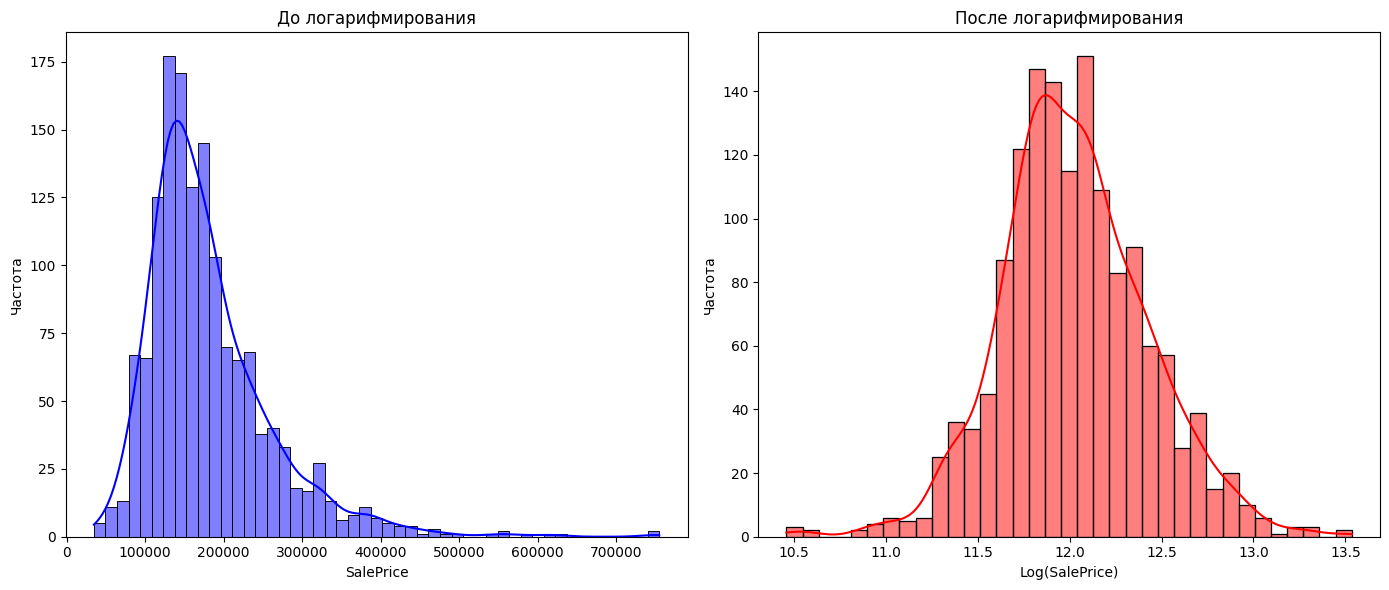

In [93]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(original_data, kde=True, color='blue')
plt.title('До логарифмирования')
plt.xlabel('SalePrice')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(log_data, kde=True, color='red')
plt.title('После логарифмирования')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

### Обучение модели

In [85]:
stack_model.fit(full_df.iloc[:index], np.log1p(y_price.values))

StackingRegressor(cv=10,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.21, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.009, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=3600, n_jobs=None,
                                            nthread=-1, num_parallel_tree=None, ...)),
                              ('ridge', Ridge(alpha=15))],
                  final_estimator=LinearRegression())

In [86]:
y_pred = stack_model.predict(full_df.iloc[:index])

## Оценка модели

In [87]:
rmse = np.sqrt(mean_squared_error(np.log1p(y_price.values), y_pred))
r2 = r2_score(np.log1p(y_price.values), y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 0.057795021594590885
R²: 0.9790513927912862


## Построение Графика остатков

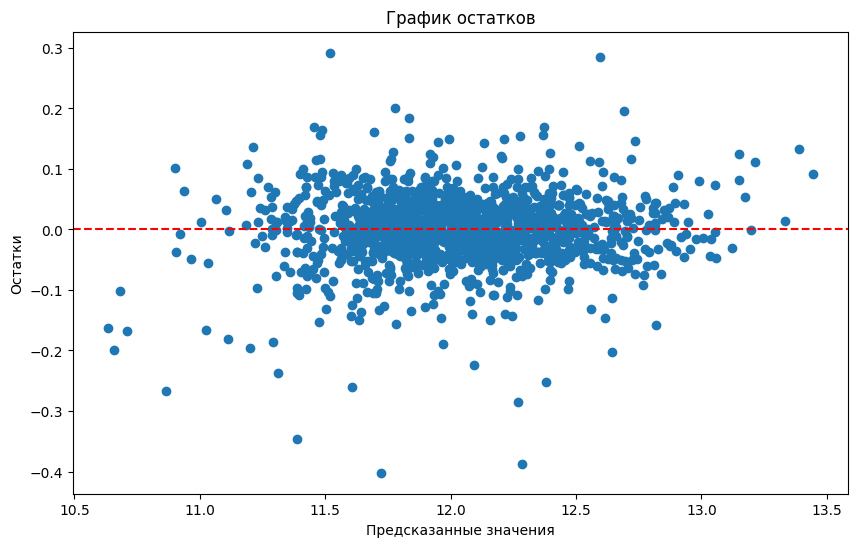

In [88]:
plt.figure(figsize=(10, 6))
residuals = np.log1p(y_price.values) - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

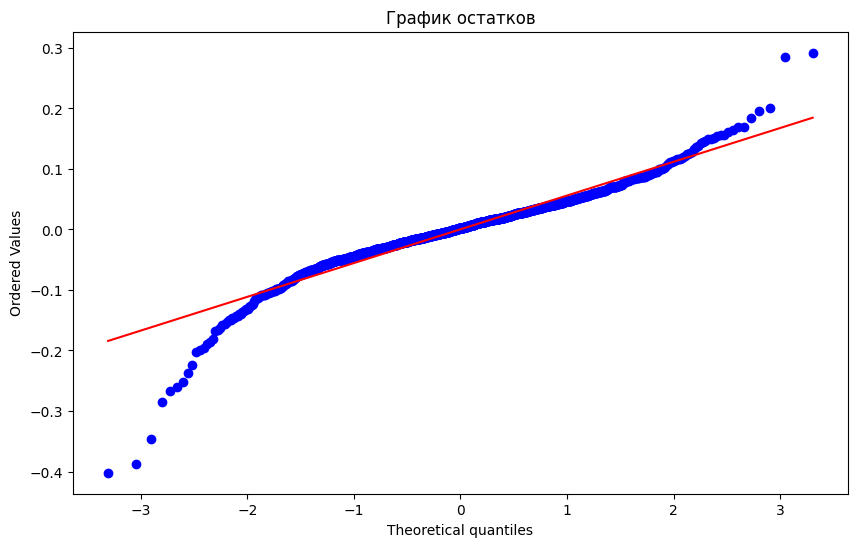

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("График остатков")
plt.show()

### Прогнозирование модели

In [90]:
df_pred = stack_model.predict(full_df)

In [91]:
output = pd.DataFrame({
    'Id' : id_[index:],
    'SalePrice' : np.exp(df_pred[index:])
})

### Сохранение результатов

In [92]:
output.to_csv('submission.csv' ,index=False)

## Kaggle score:
**Top 5% scoring: 0.11996**

**RMSE: 0.057795021594590885**

**R²: 0.9790513927912862**